# Epidemiological Model

#### Project done in pair: Mariana DUTRA DINIZ COSTA and Felipe SCHERER VICENTIN

## Introduction

In this project, we study two mathematical approaches to model the spread of an epidemic within a population: a deterministic model based on the classical SIR system of differential equations, and a stochastic model based on a Markov process simulating state transitions. The goal is to understand the differences between these two methods, analyze how the stochastic behavior converges to the deterministic behavior under certain conditions, and identify different epidemic scenarios depending on the model parameters. In particular, we aim to find parameter values that either lead to the complete infection of the population or leave a portion of individuals uninfected. Finally, we discuss how these models could be applied to real epidemiological data, such as those provided by Santé Publique France, to estimate the parameters $\beta$ and $\gamma$.

In [1]:
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp

## Deterministic SIR system

We start by implementing the deterministic SIR model, where the dynamics of an epidemic are described by a system of ODEs. The SIR model divides the population into three groups:
1. $S$: Susceptible;
2. $I$: Infected;
3. $R$: Removed (cured or dead).

The system is then determined by two parameters:
- $\beta$: the transmission rate (rate at which susceptibles become infected),
- $\gamma$: the recovery rate (rate at which infected individuals recover and move to the removed compartment).

We define a function `create_system(beta, gamma)` that returns the ODEs describing the time evolution of $(S, I, R)$. Then, the function `SIR(N, t_eval, beta, gamma)` takes as input the population size $N$, the time grid `t_eval`, and the parameters $\beta$ and $\gamma$.

The initial condition assumes that one individual is infected at time zero, and the rest of the population is susceptible. The system is then solved numerically using the `solve_ivp` solver from the `scipy.integrate` library. In the end, the function returns the simulated evolution for $S(t)$, $I(t)$, and $R(t)$.

In [2]:
def create_system(beta, gamma):
    def system(t, y):
        s, i, r = y
        
        ds = -beta * i * s
        di = beta * i * s - gamma * i
        dr = gamma * i
        
        return [ds, di, dr]
        
    return system 

In [3]:
def SIR(N, t_eval, beta, gamma):
    system = create_system(beta, gamma)
    infected = 1
    y0 = [1-infected/N, infected/N, 0]

    sol = solve_ivp(system, (0, t_eval[-1]), y0, t_eval=t_eval)
    
    return sol.y[0], sol.y[1], sol.y[2], sol.t

## Stochastic SIR system: Markov process

The next step is to implement a stochastic SIR model based on Continuous Time Markov Chains to model the random evolution of an epidemic at the individual level. In contrast to the deterministic model, the stochastic approach takes into account random fluctuations that naturally occur in finite populations.

The following functions are used to build the system simulation:

- `sample_exp(lamb)`:
This function samples an exponential random variable with parameter $\lambda$, corresponding to the time rate until the next event (either a new infection or a removal). This reflects the memoryless property of the Markov process, where the time between events is exponentially distributed.

- `sample_class(p)`:
Given an array of event probabilities $p$ (for example, the probability of infection versus recovery), this function selects which event occurs. It does so by computing cumulative probabilities, sampling a uniform random number, and choosing the corresponding event class based on where the sample falls.

- `markov_sir(N, beta, gamma, t_max)`:
This is the main function that simulates the SIR epidemic system as a stochastic process. The population is initially defined with $N$ susceptible individuals, $1$ infected individual and $0$ removed individuals. Then, at each step:

    The rates for infection and removal are computed based on the current number of susceptible and infected individuals. The total rate (sum of infection and removal rates) determines the waiting time until the next event, sampled by `sample_exp`. The specific event is then selected randomly by `sample_class` according to their relative rates.

    The population counts are updated accordingly:
    - If an infection occurs, one susceptible becomes infected.
    - If a recovery or death occurs, one infected becomes removed.
  
    The time of each event is stored and the simulation continues until there are no more infected individuals or the maximum simulation time `t_max` is reached.

Together, these three functions allow the stochastic simulation of the SIR dynamics, especially in large populations.

In [2]:
def sample_exp(lamb):
    U = np.random.rand()
    return - np.log(U) / lamb


def sample_class(p: np.array):
    if np.abs(np.sum(p) - 1) > 1e-10:
        p = p / p.sum()
        
    cum_probs = np.cumsum(p)
    U = np.random.rand()
    return np.argmax(U < cum_probs)

In [4]:
def markov_sir(N, beta, gamma, t_max):
    s, i, r = N, 1, 0

    x = [(s, i, r)]
    T = [0]

    for _ in range(t_max):
        if i == 0:
            break
        
        p_new_i = (beta * i * s) / N
        p_new_r = gamma * i
        
        p = np.array([p_new_i, p_new_r])
        epsilon = sample_exp(p.sum())

        if sample_class(p) == 0:
            s -= 1
            i += 1
        else:
            i -= 1
            r += 1

        t = T[-1] + epsilon

        x.append((s, i, r))
        T.append(t)

    return np.array(x), np.array(T)

## Running simulations

In [7]:
def plot_simulation(s_sir, i_sir, r_sir, t_sir, s_markov, i_markov, r_markov, t_markov):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    
    axs[0].plot(t_sir, s_sir, label='susceptible')
    axs[0].plot(t_sir, i_sir, label='infected')
    axs[0].plot(t_sir, r_sir, label='removed')
    axs[0].set_title('Deterministic')
    axs[0].legend()
    
    axs[1].plot(t_markov, s_markov, label='susceptible')
    axs[1].plot(t_markov, i_markov, label='infected')
    axs[1].plot(t_markov, r_markov, label='removed')
    axs[1].set_title('Markovian')
    axs[1].legend()
    
    axs[2].plot(t_markov, i_markov/i_sir, label='infected')
    axs[2].set_title('Ratio')
    axs[2].legend()
    
    fig.suptitle(f'SIR Model {N = }, {beta = }, {gamma = }')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

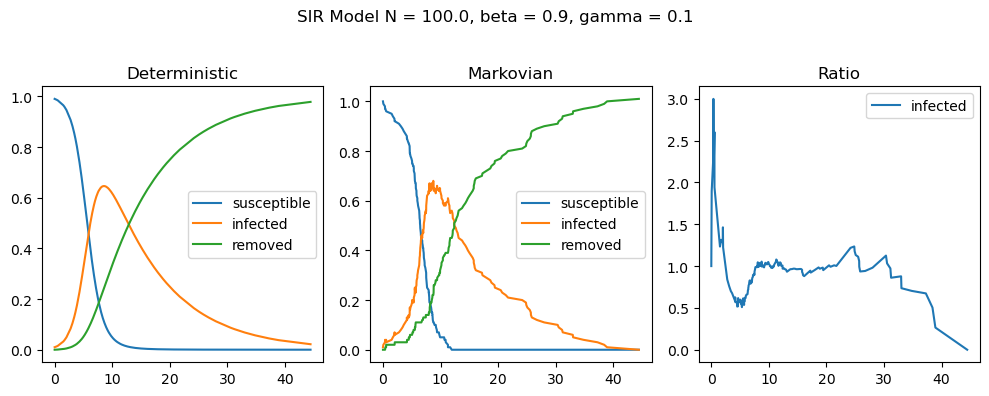

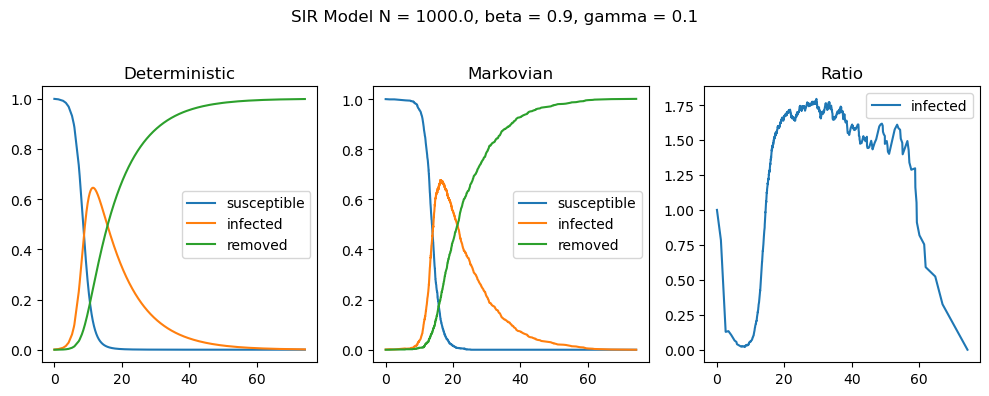

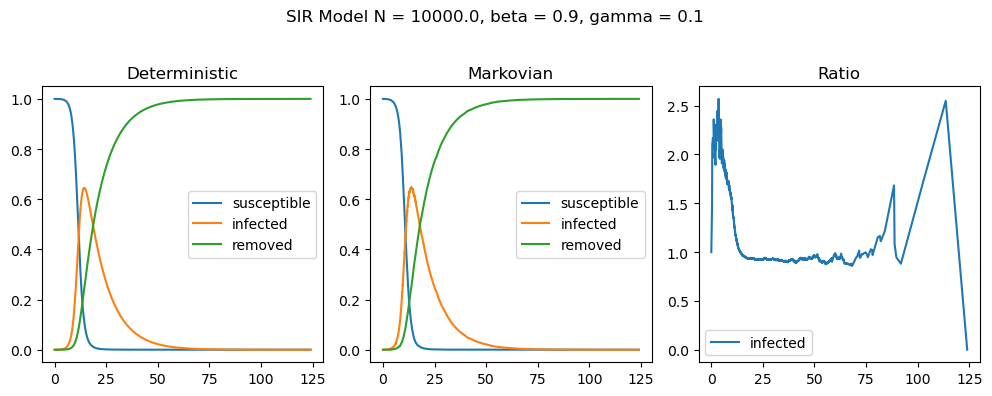

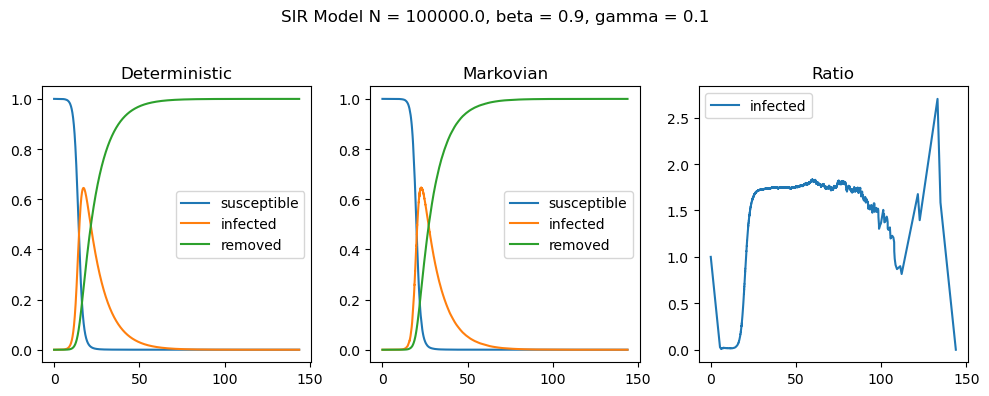

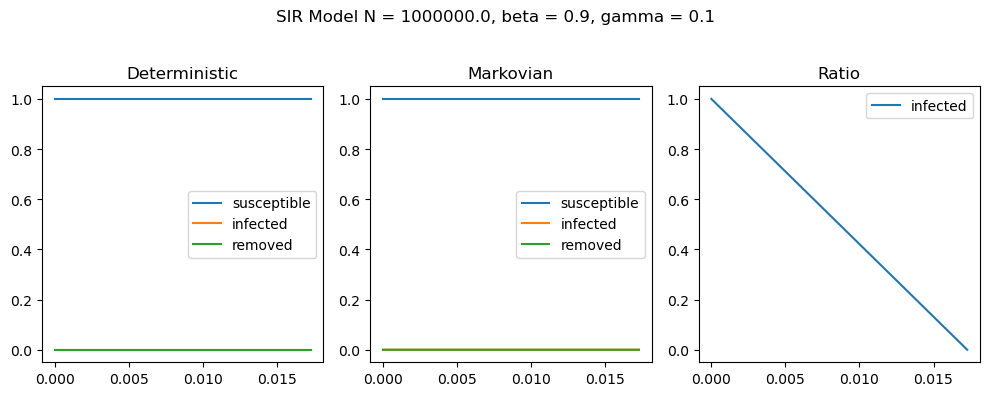

In [8]:
beta = 0.9
gamma = 0.1
T_max = 1_000_000

for N in [1e2, 1e3, 1e4, 1e5, 1e6]:
    x_markov, t_markov = markov_sir(N, beta, gamma, T_max)
    x_markov = x_markov / N

    s_markov, i_markov, r_markov = x_markov[:, 0], x_markov[:, 1], x_markov[:, 2]

    s_sir, i_sir, r_sir, t_sir = SIR(N, t_markov, beta, gamma)

    plot_simulation(s_sir, i_sir, r_sir, t_sir, s_markov, i_markov, r_markov, t_markov)

Couples de valeurs (beta, gamma) ou:
1. Tout le monde est retirée sur le long terme: (0.8, 0.08)
2. Une partie reste susceptible et autre est retirée: (0.8, 0.5)

## Données COVID

In [9]:
data = pd.read_csv('donnees-covid.csv', sep=';')

In [10]:
data.head()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,1,2020-03-19,1,0,0,0
1,1,2020-03-20,0,0,0,1
2,1,2020-03-21,3,0,0,0
3,1,2020-03-22,3,1,0,1
4,1,2020-03-23,14,1,0,5


In [11]:
data.describe()

,incid_hosp,incid_rea,incid_dc,incid_rad
count,26664.000000,26664.000000,26664.000000,26664.000000
mean,9.307456,1.474910,1.461934,6.626050
std,21.830852,4.086908,3.791728,14.156373
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,2.000000
75%,9.000000,1.000000,1.000000,7.000000
max,404.000000,96.000000,76.000000,222.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26664 entries, 0 to 26663
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dep         26664 non-null  object
 1   jour        26664 non-null  object
 2   incid_hosp  26664 non-null  int64 
 3   incid_rea   26664 non-null  int64 
 4   incid_dc    26664 non-null  int64 
 5   incid_rad   26664 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.2+ MB


In [13]:
def plot_info(data):
    plt.plot(data.incid_hosp, label='hospitalisations')
    plt.plot(data.incid_rea, label='réanimation')
    plt.plot(data.incid_dc, label='decés')
    plt.plot(data.incid_rad, label='maison')
    
    plt.legend()
    plt.show()

In [14]:
def plot_info_cum(data):
    plt.plot(np.cumsum(data.incid_hosp), label='hospitalisations')
    plt.plot(np.cumsum(data.incid_rea), label='réanimation')
    plt.plot(np.cumsum(data.incid_dc), label='decés')
    plt.plot(np.cumsum(data.incid_rad), label='maison')
    
    plt.legend()
    plt.show()

In [15]:
def plot_SIR_mov_avg(s, i, r, N):
    window_size = 7
    kernel = np.ones(window_size)/window_size

    #r = np.convolve(r, kernel, mode='valid')
    #i = np.convolve(i, kernel, mode='valid')
    #s = np.convolve(s, kernel, mode='valid')
    
    plt.plot(s / N, label='susceptibles')
    plt.plot(i / N, label='infected')
    plt.plot(r / N, label='removed')
        
    plt.legend()
    plt.show()

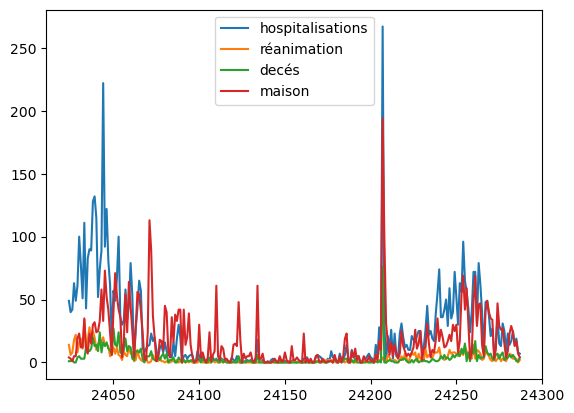

In [16]:
plot_info(data[data.dep == '91'])

In [47]:
def estimate_parameters(data, dep):
    data = data[data.dep == dep]
    data = data[:data.shape[0] // 2]
    
    window_size = 7
    kernel = np.ones(window_size)/window_size
    
    r = np.cumsum(data.incid_dc)
    i = data.incid_hosp + data.incid_rea
    #N = r.values[-1] + i.values[-1]
    N = np.max(r + i + data.incid_rad)
    s = N - i - r

    r = np.convolve(r, kernel, mode='valid')
    i = np.convolve(i, kernel, mode='valid')
    s = np.convolve(s, kernel, mode='valid')
    
    plot_SIR_mov_avg(s, i, r, N)

    r_plus = r[1:]
    i_plus = i[1:]
    
    gamma = (r_plus - r[:-1]) / i[:-1]
    beta = N * ((i_plus - i[:-1]) + (r_plus - r[:-1])) / (s[:-1] * i[:-1])
         
    
    return N, beta, gamma

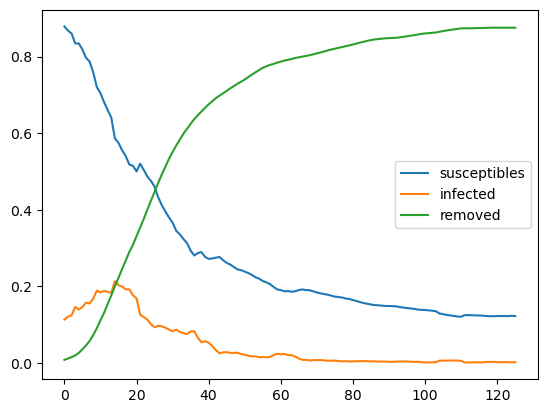

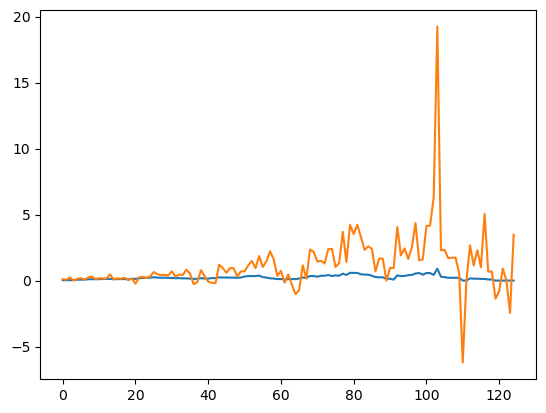

1.1968382725276374
0.2279039781066255


In [45]:
N, beta, gamma = estimate_parameters(data, '91')
plt.plot(gamma)
plt.plot(beta)
plt.show()

print(np.mean(beta))
print(np.mean(gamma))

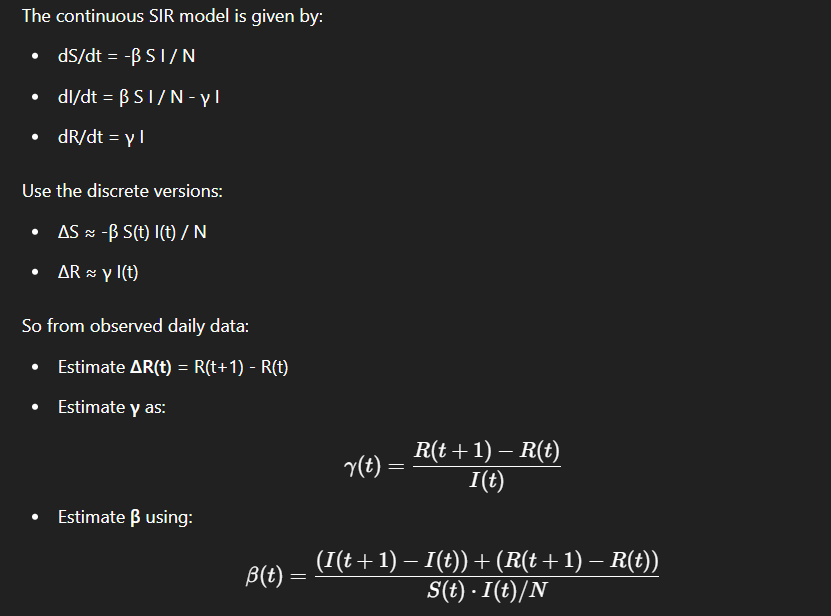

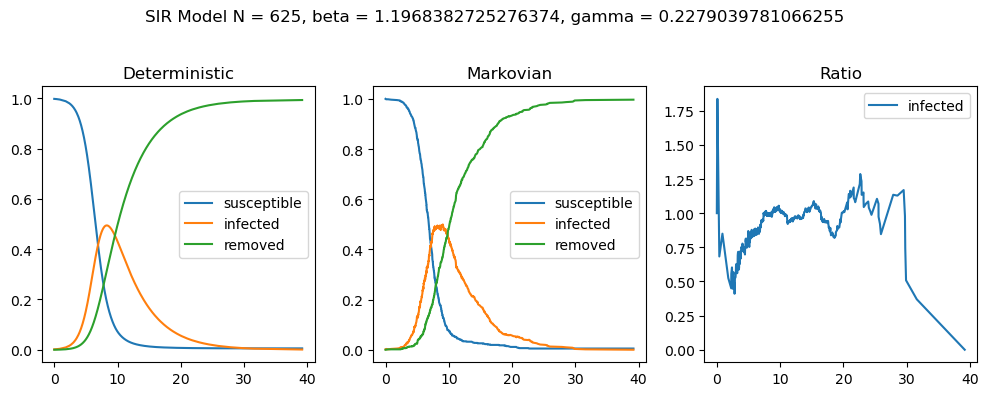

In [46]:
beta = np.mean(beta)
gamma = np.mean(gamma)
T_max = 1_000_000
N = N

x_markov, t_markov = markov_sir(N, beta, gamma, T_max)
x_markov = x_markov / N

s_markov, i_markov, r_markov = x_markov[:, 0], x_markov[:, 1], x_markov[:, 2]

s_sir, i_sir, r_sir, t_sir = SIR(N, t_markov, beta, gamma)

plot_simulation(s_sir, i_sir, r_sir, t_sir, s_markov, i_markov, r_markov, t_markov)